In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
def clean_dataset(df):
    
    variables_to_remove = ['OP_CARRIER_FL_NUM', 'DEP_TIME','ARR_TIME','TAXI_OUT', 'WHEELS_OFF','WHEELS_ON','TAXI_IN', 
                           'CANCELLED', 'CANCELLATION_CODE','DIVERTED','AIR_TIME','CARRIER_DELAY','WEATHER_DELAY',
                           'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME',
                           'Unnamed: 27','Unnamed: 0']

    df.drop(variables_to_remove, axis = 1, inplace = True)

    df=df.rename(columns={'FL_DATE':'DATE','OP_CARRIER':'AIRLINE','DEST':'DESTIN',
                    'CRS_DEP_TIME':'SCHED_DEPARTURE','DEP_DELAY':'DEPARTURE_DELAY',
                    'CRS_ARR_TIME':'SCHED_ARRIVAL','ARR_DELAY':'ARRIVAL_DELAY'})

    df.dropna(inplace = True)
    
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d', errors = 'coerce')
    
    return df


def format_hour(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

def combine_date(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
def transform_hour(df):
    df['SCHED_DEPARTURE'] = df['SCHED_DEPARTURE'].apply(format_hour)
    df['SCHED_ARRIVAL'] = df['SCHED_ARRIVAL'].apply(format_hour)
    
    return df

def create_flight_time(df):    
    lista=[]
    for i,v in df[['DATE','SCHED_DEPARTURE']].iterrows() :   #iteration over rows
    
        try :
            lista.append(datetime.datetime.combine(df['DATE'][i],df['SCHED_DEPARTURE'][i]))
        except:
            lista.append('error')        #if something goes wrong lista appens 'error'

    indices = [i for i, x in enumerate(lista) if x == "error"]   #test of lista to see if it'ok
    print ('Errors during data transformation :  ', len(indices))

    df['DATE_TIME']=lista
    return df

def percentile(df):
    df['DELAY_LEVEL']=df.ARRIVAL_DELAY.rank(pct=True)
    
    return df

def airline_name(df):
    
    df["AIRLINE_NAME"]=df.apply(lambda x: airlines.loc
                           [airlines['CODE'] == x["AIRLINE"],"AIRLINE"].values[0],axis=1)
    return df

def geo (df):
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='ORIGIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'OR_LATITUDE','LONGITUDE':'OR_LONGITUDE'})
   
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='DESTIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'DEST_LATITUDE','LONGITUDE':'DEST_LONGITUDE'})
    
    return df

def drop_code (df):
    variables_to_remove=['IATA_CODE_x','IATA_CODE_y']
    df=df.drop(variables_to_remove,axis = 1)
    return df

def outlier (df):
    #Outliers 
    # Drop'ARRIVAL_DELAY'>300 and 'ARRIVAL_DELAY'<-50
    outlier1 = df['ARRIVAL_DELAY']>300
    outrmv=df.index[outlier1].tolist()
    df=df.drop(outrmv)
    outlier2 = df['ARRIVAL_DELAY']<-50
    outrmv=df.index[outlier2].tolist()
    df=df.drop(outrmv)
    return df
    

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [4]:
airports = pd.read_csv("dict/airports.csv")
airlines = pd.read_csv('dict/allairlines.csv', sep=';')
airlines_dict = airlines.set_index('CODE')['AIRLINE'].to_dict()
identify_airport = airports.set_index('IATA_CODE')['AIRPORT'].to_dict()
latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [5]:
df= pd.read_csv("data/2014.csv")
df_rnd=df.sample(frac = 0.1)
df_rnd.to_csv('sample/sample_2014.csv')

In [47]:
# Primero especificamos un patrón del archivo y lo pasamos como parámetro en la función glob
csv_files = glob.glob('sample/*.csv')
#csv_files = glob.glob('data/*.csv')
# Mostrar el archivo csv_files, el cual es una lista de nombres
print(csv_files)

['sample\\sample_2014.csv']


In [55]:
list_data = []
p = Path('clean/')
# Escribimos un loop que irá a través de cada uno de los nombres de archivo 
# Aplicamos las funciones en el bucle

for filename in csv_files:
    data = pd.read_csv(filename)
    #Cleaning
    data = clean_dataset(data)
    #Datetime Transform
    data = transform_hour(data)
    data = create_flight_time (data)
    #Outliers
    data = outlier(data)
    #Percentile
    data = percentile(data)
    #Airlines names
    data = airline_name(data)
    #Geo
    data = geo(data)
    data = drop_code(data)
    #Saving
    data.to_csv((Path(p, filename)), index=False)
    list_data.append(data)

Errors during data transformation :   567833


In [1]:
list_data[0].head(20)

NameError: name 'list_data' is not defined

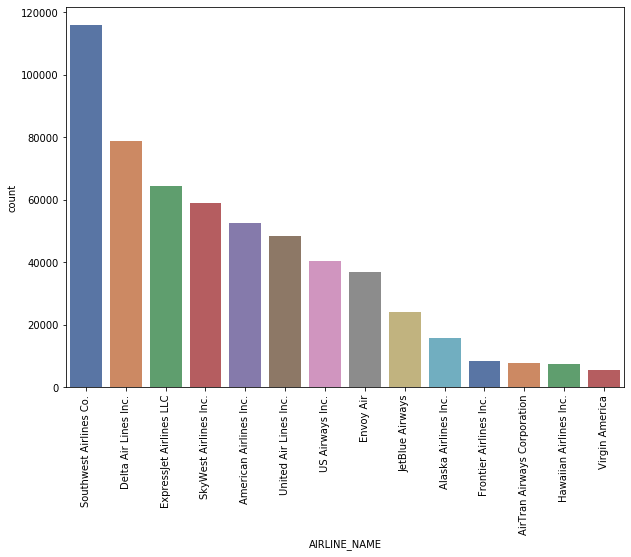

In [34]:
#AIRLINE DECISION
#
plt.figure(figsize=(10,7))
g=sns.countplot(x='AIRLINE_NAME', data=list_data[0], palette="deep", order = list_data[0]['AIRLINE_NAME'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

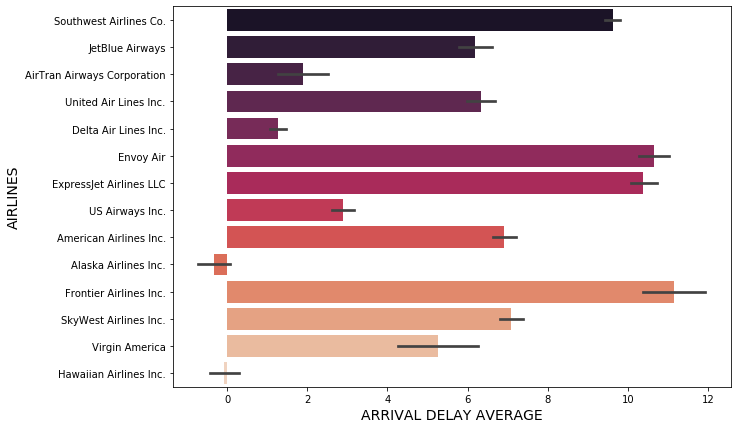

In [35]:
# AIRLINE DELAY AVERAGE
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY",data=list_data[0],palette='rocket')
plt.xlabel('ARRIVAL DELAY AVERAGE', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.show()

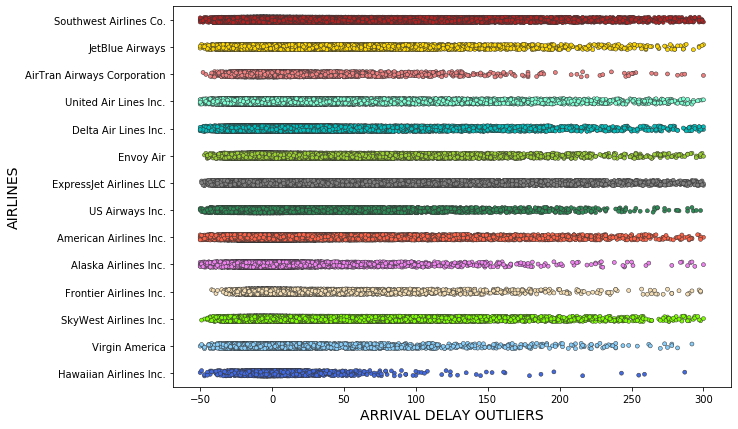

<Figure size 720x504 with 0 Axes>

In [36]:
# CHECKING OUTLIERS
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
plt.figure(figsize=(10,7))
ax2=sns.stripplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY", size = 4, palette = colors,
                    data=list_data[0], linewidth = 0.5,  jitter=True)
plt.xlabel('ARRIVAL DELAY OUTLIERS', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.figure(figsize=(10,7))
plt.show()

In [28]:
# American Airlines (AA)
df_AA=list_data[0][list_data[0]['AIRLINE']=='AA']

In [39]:
variables_to_remove=['AIRLINE','AIRLINE_NAME','OR_LATITUDE', 'OR_LONGITUDE', 'DEST_LATITUDE', 
                 'DEST_LONGITUDE','DEPARTURE_DELAY','ARRIVAL_DELAY']
df_AA=df_AA.drop(variables_to_remove, axis=1)

In [41]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,DISTANCE,DELAY_LEVEL
3665,2014-03-31 12:20:00,MIA,BWI,08:05:00,10:40:00,946.0,0.133225
3666,2014-03-17 10:44:00,MIA,BWI,08:05:00,10:40:00,946.0,0.610892
3667,2014-01-09 11:30:00,MIA,BWI,14:10:00,16:40:00,946.0,0.793169
3668,2014-05-26 16:32:00,MIA,BWI,14:05:00,16:40:00,946.0,0.401924
3669,2014-08-16 12:45:00,MIA,BWI,21:40:00,00:15:00,946.0,0.175742
...,...,...,...,...,...,...,...
4902,2014-04-16 22:41:00,DFW,BWI,19:25:00,23:15:00,1217.0,0.225391
4903,2014-08-05 10:05:00,DFW,BWI,15:05:00,18:50:00,1217.0,0.747008
4904,2014-10-06 11:20:00,DFW,BWI,11:45:00,15:30:00,1217.0,0.401924
4905,2014-07-25 10:45:00,DFW,BWI,09:20:00,13:15:00,1217.0,0.252453


In [54]:
df_AA['DATE_TIME']=pd.to_datetime(df_AA['DATE'], format= '%Y-%m-%d %H:%M:%S')
df_AA['MONTH']=[ x.month for x in df_AA['DATE']]
df_AA['HOUR']=[ x.hour for x in df_AA['DATE']]

#to date_time
df_AA['SCHED_DEPARTURE']=pd.to_datetime(df_AA['SCHED_DEPARTURE'], format= '%H:%M:%S') #to date_time
conversion = lambda x:x.hour*3600+x.minute*60+x.second 
df_AA['SCHEDULED_DEPARTURE']= np.array([conversion(s) for s in df_AA['SCHED_DEPARTURE']]) #conversion to seconds


df_AA_DATE=df_AA.groupby(df_AA['DATE']).mean()

print(df_AA_DATE.head(10))

C:\Users\alex_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\alex_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alex_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

                     DEPARTURE_DELAY  ARRIVAL_DELAY  SCHED_FLIGHT_DURATION  \
DATE                                                                         
2014-01-01 00:45:00             38.0           53.0                  180.0   
2014-01-01 05:34:00             -3.0          -19.0                  255.0   
2014-01-01 06:00:00             -6.0          -14.0                  250.0   
2014-01-01 06:15:00              3.0            1.0                  120.0   
2014-01-01 06:25:00             -1.0            9.0                  135.0   
2014-01-01 07:00:00             20.0           -2.0                  155.0   
2014-01-01 07:07:00             14.0           18.0                  265.0   
2014-01-01 07:20:00              9.0           15.0                  115.0   
2014-01-01 07:29:00             -2.0          -22.0                  240.0   
2014-01-01 07:55:00             -3.0           -9.0                  140.0   

                     FLIGHT_DURATION  DISTANCE  DELAY_LEVEL  MO

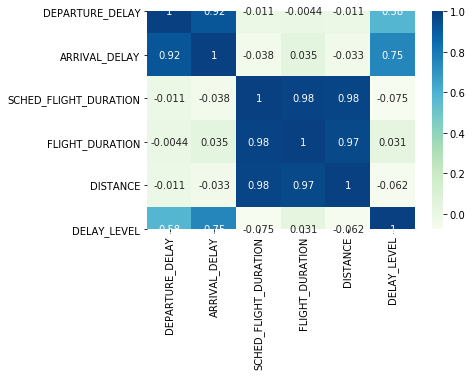

In [36]:
#CORRELATION MATRIX (Pearson Correlation)
corrmat=df_AA.corr()
ax = sns.heatmap(corrmat, annot=True, cmap="GnBu")

In [ ]:
#CLASIFICACIÓN
#Random forest
#sample aleatorio de un año
#Separamos la columna con la información del delay_level
X = np.array(df_AA.drop(['DELAY_LEVEL'],1))
y = np.array(df_AA['DELAY_LEVEL'])

In [ ]:
#Separamos los datos en train y test, con una proporción de un 70% y 30%, respectivamente.
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

In [ ]:
rnd_forest = RandomForestClassifier()
rnd_forest.fit(X_train, y_train)
y_pred_rnd_forest = rnd_forest.predict(X_test)

In [ ]:
#Precisión en la clasificación de los valores de entrenamiento
acc_rnd_forest_train = round(rnd_forest.score(X_train, y_train) * 100, 2)
print (acc_rnd_forest_train)

In [ ]:
# Precisión en la clasificación de los valores de test
acc_rnd_forest = accuracy_score(y_test, y_pred_rnd_forest)
print (acc_rnd_forest*100)

In [ ]:
# Matriz de confusión
confusion_matrix(y_test, y_pred_rnd_forest)